# Poisoning

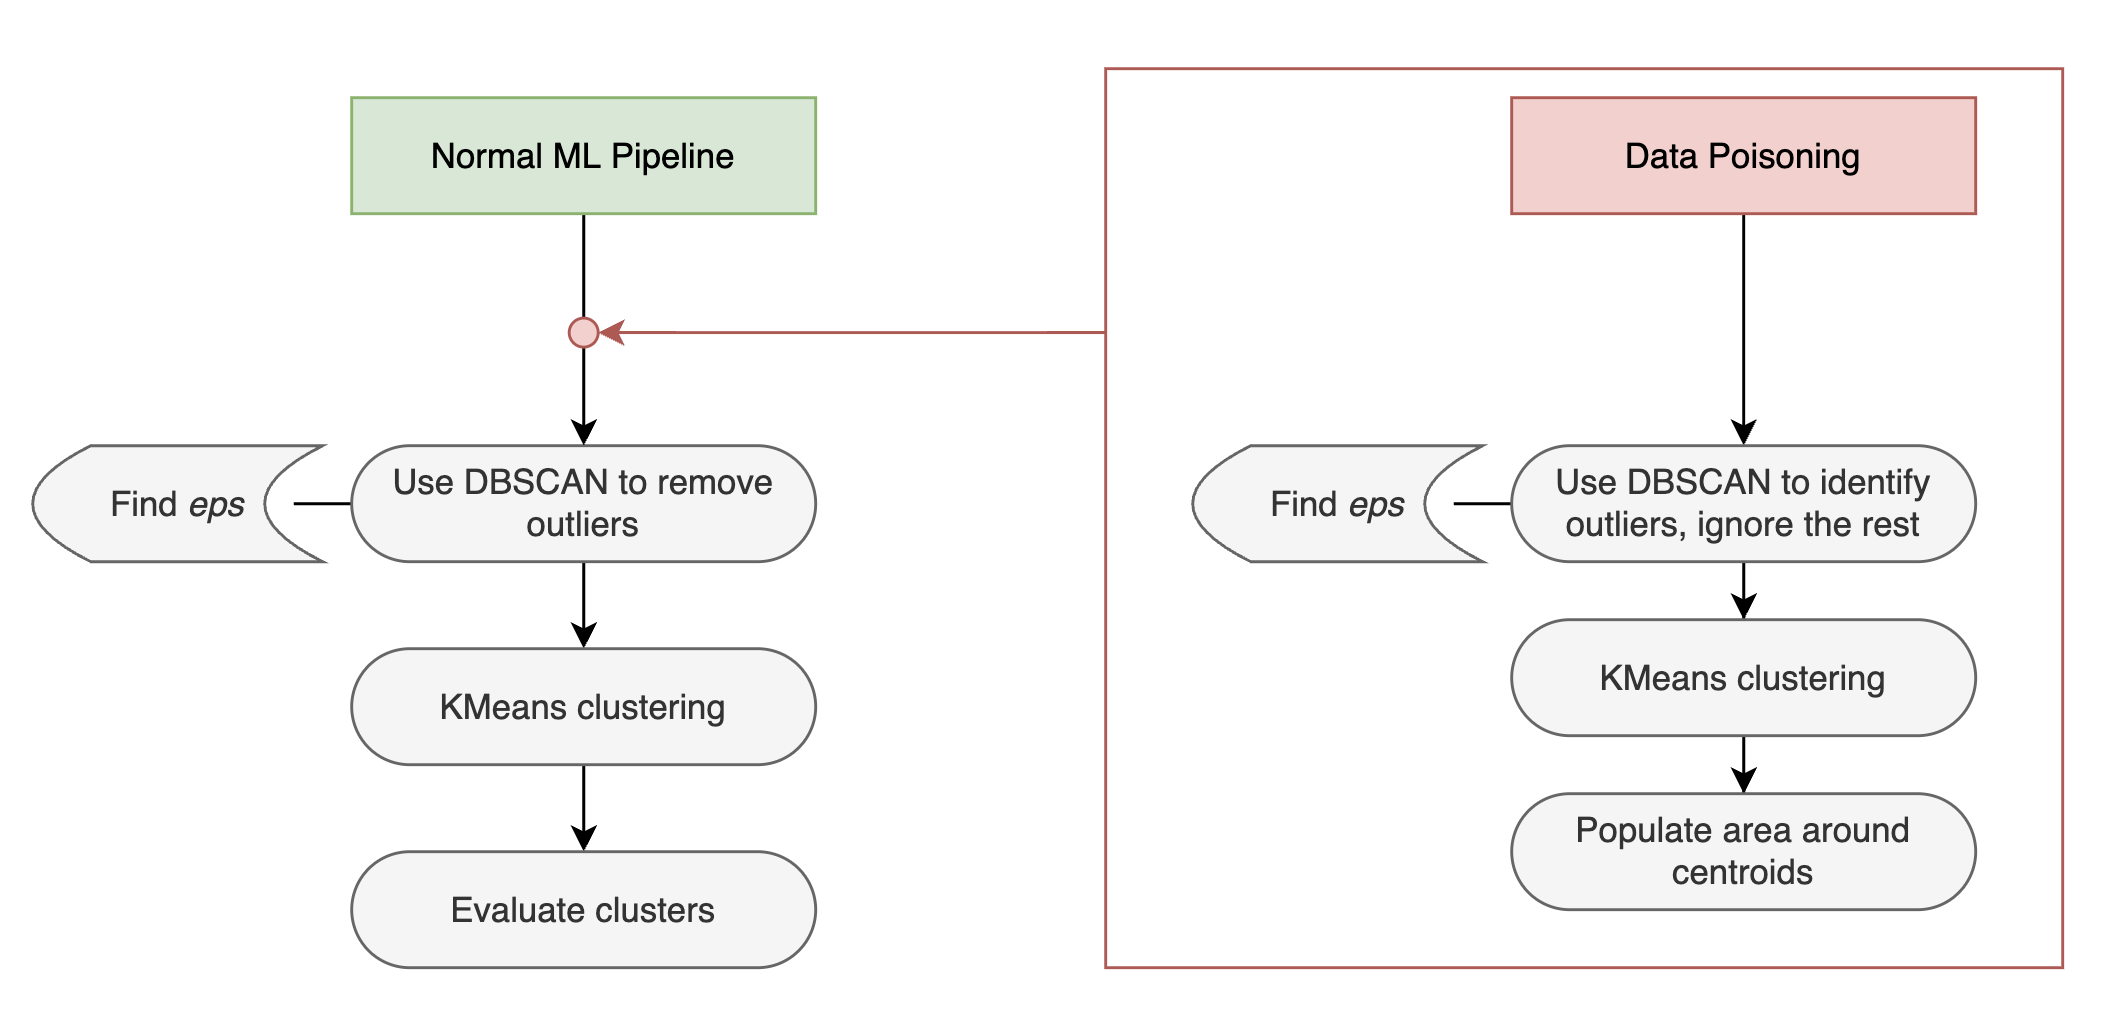

## Setup

In [44]:
!pip install -U kaleido --quiet

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from sklearn.neighbors import NearestNeighbors
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from IPython.display import Image

In [46]:
RAND = 10

## Dataset

In [47]:
data = datasets.load_iris()

columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
labels = data.target_names.tolist()

In [48]:
iris, iris_target = pd.DataFrame(data.data, columns=columns), data.target

## Exploratory Data Analysis

In [49]:
(iris.shape, iris_target.shape)

((150, 4), (150,))

In [50]:
iris.columns.tolist()

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [51]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [52]:
iris_target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Preprocessing

In [53]:
X = iris.copy().drop('petal_length', axis=1)
y = iris_target.copy()

## Preparation

In [54]:
def find_eps(_data, k=5):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors.fit(_data)

    distances, indices = neighbors.kneighbors(_data)
    distances = np.sort(distances[:, -1], axis=0)

    plt.plot(distances)
    plt.title('K-distance Graph (Elbow Plot)')
    plt.xlabel('Data point')
    plt.ylabel(f'Distance to {k}-th Nearest Neighbor')
    plt.grid(True)
    plt.show()

In [55]:
def visualize_clustering(_data, _centroids, centroid_color="blue"):
    point_layer = go.Scatter3d(
        x=_data['sepal_length'],
        y=_data['sepal_width'],
        z=_data['petal_width'],
        mode='markers',
        marker=dict(size=3, color="grey", line=dict(color='black', width=0.5)),
        name="cleaned data"
    )

    centroid_layer = go.Scatter3d(
        x=_centroids[:, 0],
        y=_centroids[:, 1],
        z=_centroids[:, 2],
        mode='markers',
        marker=dict(symbol="cross", size=10, color=centroid_color),
        name="centroid"
    )

    layout = go.Layout(
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        )
    )

    fig = go.Figure(data=[point_layer, centroid_layer], layout=layout)
    fig.show()
    return fig

## Normal Pipeline

In [56]:
# 0. Hyperparameters
epsilon = None
n_clusters = 3

# 1. Hyperparameter initialization for DBSCAN
## find_eps(X)
epsilon = 0.4

# 2. DBSCAN, purge outliers
clustering = DBSCAN(eps=epsilon).fit(X)
is_inlier = clustering.labels_ != -1
x_normal = X[is_inlier]

# 3. KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=RAND)
kmeans.fit(x_normal)
normal_centroids = kmeans.cluster_centers_

# 4. Visualize clustering
fig = visualize_clustering(x_normal, normal_centroids, centroid_color="seagreen")

# 5. Evaluate clustering
## ...

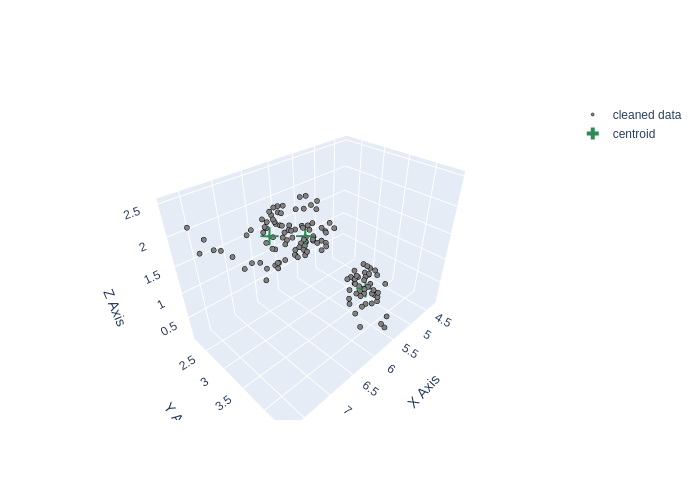

In [57]:
fig.write_image("original_clustering.png")
Image(filename="original_clustering.png")

## Poisoned Pipeline

In [58]:
X_to_fit = X.copy()

# 0. Hyperparameters
epsilon = None
n_clusters = 3

#############################################
# Poisoning Starts                          #
#############################################

injection_centroid_wise_n = 100
injection_std = 0.1
injection_mean = 0

# P1. Hyperparameter initialization for DBSCAN
## find_eps()
epsilon = 0.4

# P2. DBSCAN, keep only outliers
clustering = DBSCAN(eps=epsilon).fit(X_to_fit)
is_outlier = clustering.labels_ == -1
x_outlier = X_to_fit[is_outlier]

# P3. KMeans clustering of outliers
kmeans = KMeans(n_clusters=n_clusters, random_state=RAND)
kmeans.fit(x_outlier)
outlier_centroids = kmeans.cluster_centers_

# P4. Populate outlier region

poisoned_data = X_to_fit.copy()

for i in range(n_clusters):
    for j in range(injection_centroid_wise_n):
        _injection = outlier_centroids[i] + np.random.normal(injection_mean, injection_std, n_clusters)
        poisoned_data.loc[len(poisoned_data)] = _injection

X_to_fit = poisoned_data

#############################################
# Poisoning Ends                            #
#############################################

# 1. Hyperparameter initialization for DBSCAN
## find_eps(X_to_fit)
epsilon = 0.15

# 2. DBSCAN, purge outliers
clustering = DBSCAN(eps=epsilon).fit(X_to_fit)
is_inlier = clustering.labels_ != -1
x_normal = X_to_fit[is_inlier]

# 3. KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=RAND)
kmeans.fit(x_normal)
normal_centroids = kmeans.cluster_centers_

# 4. Visualize clustering
fig = visualize_clustering(x_normal, normal_centroids, centroid_color="red")

# 5. Evaluate clustering
## ...

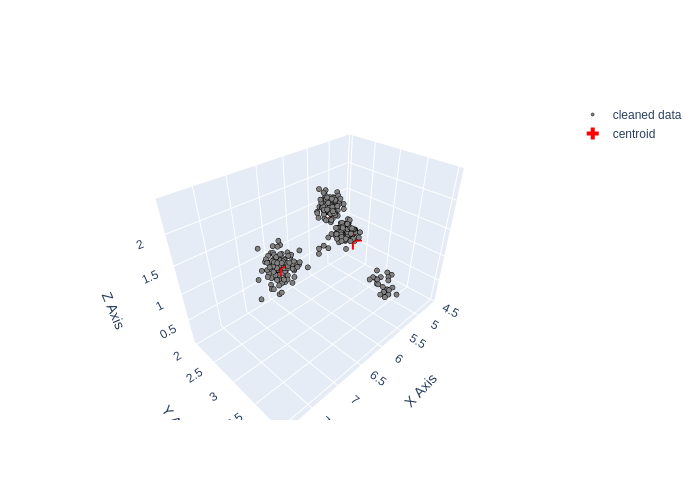

In [59]:
fig.write_image("poisoned_clustering.png")
Image(filename="poisoned_clustering.png")